## I.1. Install

In [1]:
# # # GOOGLE Colab ONLY : Mount GOOGLE Drive
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
# GOOGLE Colab ONLY : Get & store the default work path
user_path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks")

# LOCAL : Get & store the current working path
# user_path = os.path.dirname(os.path.abspath("NoNeedFilename"))

print(user_path)

/content/drive/MyDrive/Colab Notebooks


In [3]:
# requirements_filepath = os.path.join(user_path, "requirements.txt")
# !pip install -r {requirements_filepath}

## I.2. Libraries Import

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning
# import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from keras.applications import EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3

## I.4. Image Processing

### I.4.2. Set Image Folder Path

In [5]:
# GOOGLE Colab ONLY
train_dir = os.path.join(user_path, "IMAGE_SPLIT", "train")
val_dir = os.path.join(user_path, "IMAGE_SPLIT", "val")
test_dir = os.path.join(user_path, "IMAGE_SPLIT", "test")

# LOCAL
# train_dir = r"C:\WORKSPACES\DATA\ML_DL\IMAGE_SPLIT\train"
# val_dir = r"C:\WORKSPACES\DATA\ML_DL\IMAGE_SPLIT\val"
# test_dir = r"C:\WORKSPACES\DATA\ML_DL\IMAGE_SPLIT\test"

### I.4.3. Data augmentation techniques

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [0.9, 1.25],
    brightness_range = [0.5, 1.5],
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

### I.4.4. Setup Data generators

In [7]:
# Variables
batch_size = 32
height = 240
width = 240
image_shape = (height, width) # images of size 240x240 px with 3 color channels RGB automatically

train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

Found 4200 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## II.1. Define variables and parameters

In [8]:
from keras.metrics import Precision, Recall, AUC

# Model to use for transfer learning
model_name = "EfficientNetV2B1"
ModelNameFunc = globals()[model_name]

# Work path
folder_name = f"{model_name}_L1N64L2N32RMS"
work_path = os.path.join(user_path, folder_name)

# Top Architecture for the new model
l1_neurons = 64                 # Number of neurons on layer 1 (deeper)
l1_activation = "relu"
dropout = 0.4                   # 0.2 - 0.5
l2_neurons = 32                 # Number of neurons on layer 2
l2_activation = "relu"
output_neurons = 3              # This layer will have 3 neurons or units fully connected. In line with our 3 classes.
output_activation = "softmax"

# Metrics (parameter average = "macro" by default )
precision = Precision(name = "Precision")
recall = Recall(name = "Recall")
# f1 = (2 * (precision * recall) / (precision + recall))
# auc = AUC(name = "AUC")

# TRAIN : model.compile
compile_optimizer = "RMSprop"                  # Test : Nadam, RMSprop, SGD
compile_loss = "categorical_crossentropy"   # More than 2 classes, so categorical
compile_metrics = ["accuracy", precision, recall]

# TRAIN : model.fit
epochs = 30
verbose = 1

# FINE TUNE : model.compile
ft_compile_optimizer = RMSprop(learning_rate = 1e-5)
# ft_compile_optimizer : Very low learning rate. Test : Nadam, RMSprop, SGD
ft_compile_loss = "categorical_crossentropy"
ft_compile_metrics = ["accuracy", precision, recall]

# FINE TUNE : model.fit
ft_epochs = 15
ft_verbose = 1

# SAVE : File Path .h5
fileh5_path = os.path.join(work_path, f"{folder_name}_H5_Model", f"{folder_name}_TRAIN_ManualSave.h5")
ft_fileh5_path = os.path.join(work_path, f"{folder_name}_H5_Model", f"{folder_name}_FT_ManualSave.h5")

## II.2. Define optimizations

### II.2.1. Train optimizations (callbacks)

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger

# Define the early stopping
early_stopping = EarlyStopping(
    monitor = "val_loss",        # Metric to monitor
    patience = 5,                # Number of epochs with no improvement  (around 10% of nb of epochs)
    verbose = 1,                 # Verbosity mode (0, 1, or 2)
    restore_best_weights = True  # Whether to restore model weights to the best epoch
)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",       # Metric to monitor
    factor = 0.2,               # Factor by which to reduce the learning rate
    patience = 5,               # Number of epochs with no improvement (default = 10)
    verbose = 1,                # Verbosity mode (0, 1, or 2)
    min_lr = 1e-6               # Minimum learning rate
)

# Define the model checkpoint callback
checkpoint = ModelCheckpoint(
    # filepath = os.path.join(work_path, f"{model_name}_TRAIN_CheckPoint"), # to use if don't wanna save to a .h5 or .keras file
    filepath = os.path.join(work_path, f"{folder_name}_H5_Model", f"{folder_name}_TRAIN_MCPBest.h5"),
    monitor = "val_loss",       # Metric to monitor
    save_freq = "epoch",        # Default = epoch
    save_weights_only = False,  # Default = False
    save_best_only = True,      # Save only if the monitored metric improves
    mode = "min",               # "min" if monitoring loss, "max" if monitoring accuracy
    verbose = 1                 # Verbosity mode (0, 1, or 2)
)

# Define TensorBoard Logs
log_dir = os.path.join(work_path, f"{folder_name}_LOGS_TRAIN")
tensorboard = TensorBoard(
    log_dir = log_dir,
    write_graph = True,
    write_images = True,
    update_freq = "epoch"
)

# Define CSVLogger
CSV_Log_filename = os.path.join(work_path, f"{folder_name}_TRAIN.log")
CSV_Logger = CSVLogger(
    CSV_Log_filename,
    separator = "|",
    append = False
)

# Define the callbacks list
callbacks_list = [early_stopping, lr_scheduler, checkpoint, tensorboard, CSV_Logger]

### II.2.2. Fine Tune Optimization

In [10]:
# Define the FT Early stopping
ft_early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    verbose = 1,                 # Verbosity mode (0, 1, or 2)
    restore_best_weights = True  # Whether to restore model weights to the best epoch
)

# Define the FT Learning rate scheduler
ft_lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",  # Metric to monitor
    factor = 0.2,          # Factor by which to reduce the learning rate
    patience = 3,          # Number of epochs with no improvement (default = 10)
    verbose = 1,           # Verbosity mode (0, 1, or 2)
    min_lr = 1e-6          # Minimum learning rate
)

# Define the FT checkpoint callback
ft_checkpoint = ModelCheckpoint(
    # filepath = os.path.join(work_path, f"{model_name}_FT_CheckPoint"), # to use if don't wanna save to a .h5 or .keras file
    filepath = os.path.join(work_path, f"{model_name}_H5_Model", f"{model_name}_FT_MCPBest.h5"),
    monitor = "val_loss",       # Metric to monitor
    save_freq = "epoch",        # Default = epoch
    save_weights_only = False,  # Default = False
    save_best_only = True,      # Save only if the monitored metric improves
    mode = "min",               # "min" if monitoring loss, "max" if monitoring accuracy
    verbose = 1                 # Verbosity mode (0, 1, or 2)
)

# Define the FT TensorBoard Logs
ft_log_dir = os.path.join(work_path, f"{folder_name}_LOGS_FT")
ft_tensorboard = TensorBoard(
    log_dir = ft_log_dir,
    write_graph=True,
    write_images=True,
    update_freq = "epoch"
)

# Define the FT CSVLogger
ft_CSV_Log_filename = os.path.join(work_path, f"{folder_name}_FT.log")
ft_CSV_Logger = CSVLogger(
    ft_CSV_Log_filename,
    separator = "|",
    append = False
)

# Define the FT callbacks list
ft_callbacks_list = [ft_early_stopping, ft_lr_scheduler, ft_checkpoint, ft_tensorboard, ft_CSV_Logger]

## II.3. Pre train the model

### II.3.1. Instantiate a base model with pre-trained model and weights

In [11]:
# First instantiate a base model with pre-trained weights
base_model = ModelNameFunc(
    include_top = False,
    weights = "imagenet",
    include_preprocessing = False, # ONLY for V2 model, otherwise put it as comment.
    input_shape = (height, width, output_neurons)
)

28456008/28456008 [==============================] - 0s 0us/step


In [12]:
display(base_model.input)

<KerasTensor: shape=(None, 240, 240, 3) dtype=float32 (created by layer 'input_1')>

### II.3.2. Define the new architecture on top

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # Pooling
x = Dense(l1_neurons, activation = l1_activation)(x)
x = Dropout(dropout)(x)
x = Dense(l2_neurons, activation = l2_activation)(x)
x = BatchNormalization()(x)

predictions = Dense(output_neurons, activation = output_activation)(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [14]:
print(model.input_shape)

(None, 240, 240, 3)


### II.3.4. Compile the model

In [15]:
model.compile(
    optimizer = compile_optimizer,
    loss = compile_loss,
    metrics = compile_metrics
)

### II.3.5. Train the model
It's called "history" because it essentially keeps a historical record of various metrics and data related to how the model performed during training.

In [16]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = epochs,
    verbose = verbose,
    callbacks = callbacks_list
)

# Save the model
model.save(fileh5_path)

Epoch 1/30
132/132 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8867 - Precision: 0.9098 - Recall: 0.8648
Epoch 1: val_loss improved from inf to 0.21603, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNetV2B1_L1N64L2N32RMS/EfficientNetV2B1_L1N64L2N32RMS_H5_Model/EfficientNetV2B1_L1N64L2N32RMS_TRAIN_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 1826s 13s/step - loss: 0.3095 - accuracy: 0.8867 - Precision: 0.9098 - Recall: 0.8648 - val_loss: 0.2160 - val_accuracy: 0.9350 - val_Precision: 0.9389 - val_Recall: 0.9350 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9326 - Precision: 0.9386 - Recall: 0.9243
Epoch 2: val_loss improved from 0.21603 to 0.09746, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNetV2B1_L1N64L2N32RMS/EfficientNetV2B1_L1N64L2N32RMS_H5_Model/EfficientNetV2B1_L1N64L2N32RMS_TRAIN_MCPBest.h5
132/132 [==============================] - 123s 930ms/step - loss: 0.2078 - accuracy: 0.9326 - Precision: 0.9386 - Recall: 0.9243 - val_loss: 0.0975 - val_accuracy: 0.9633 - val_Precision: 0.9657 - val_Recall: 0.9625 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9488 - Precision: 0.9551 - Recall: 0.9410
Epoch 3: val_loss improved from 0.09746 to 0.0548

### II.3.7. Evaluate Pre trained model

In [17]:
# Predict the values from the Test Dataset
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# Convert predictions classes from one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)

19/19 [==============================] - 239s 13s/step


In [18]:
# Evaluate the model on the Test Dataset using `evaluate`
# f1 = F1Score(test_generator.classes, Y_pred_classes)
f1 = f1_score(test_generator.classes, Y_pred_classes, average = "macro")
print("F1 Score : ", f1)
print("Evaluate on Test Data")
results = model.evaluate(test_generator, batch_size = batch_size)

F1 Score :  0.9849567794827206
Evaluate on Test Data
19/19 [==============================] - 5s 285ms/step - loss: 0.0423 - accuracy: 0.9850 - Precision: 0.9850 - Recall: 0.9850


### II.3.8. Plot the Accuracy and the loss graphs

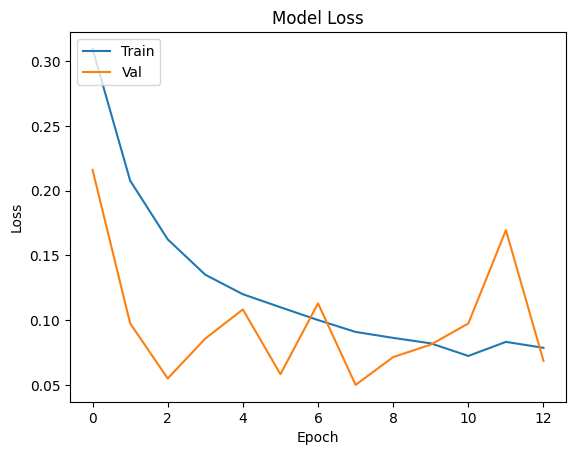

In [19]:
# Plot the Loss graph
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

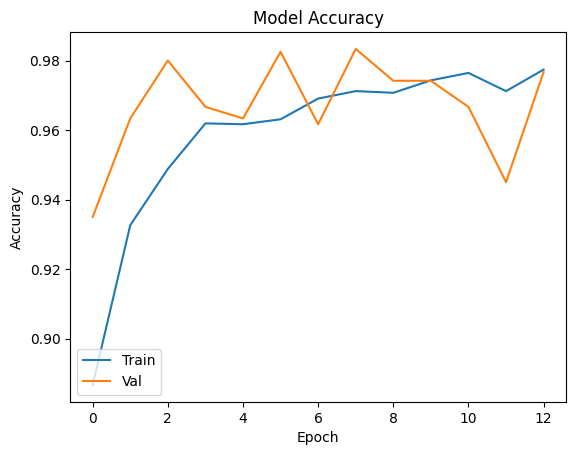

In [20]:
# Plot the Accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

### II.3.8. Trained Model : Confusion Matrix

In [21]:
# # Predict the values from the Test Dataset
# Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# # Convert predictions classes from one hot vectors
# Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convert validation observations from one hot vectors
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OR
Y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix")
print(cm)

# Retrieve class names (label)
names_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(names_from_dir))
#OR
class_names = list(val_generator.class_indices.keys())
# Check if the both are similar
print(names_from_dir == class_names)

# Print the classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names, digits = 4))


Confusion Matrix
[[198   2   0]
 [  5 193   2]
 [  0   0 200]]
True
Classification Report
              precision    recall  f1-score   support

         Bee     0.9754    0.9900    0.9826       200
   Butterfly     0.9897    0.9650    0.9772       200
     Ladybug     0.9901    1.0000    0.9950       200

    accuracy                         0.9850       600
   macro avg     0.9851    0.9850    0.9850       600
weighted avg     0.9851    0.9850    0.9850       600



### II.3.9. Confusion Matrix Function

In [22]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize = False,
    title = "Confusion matrix",
    cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis =1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### II.3.10. Trained Model : Confusion Matrix Graph

Normalized confusion matrix
[[0.99  0.01  0.   ]
 [0.025 0.965 0.01 ]
 [0.    0.    1.   ]]


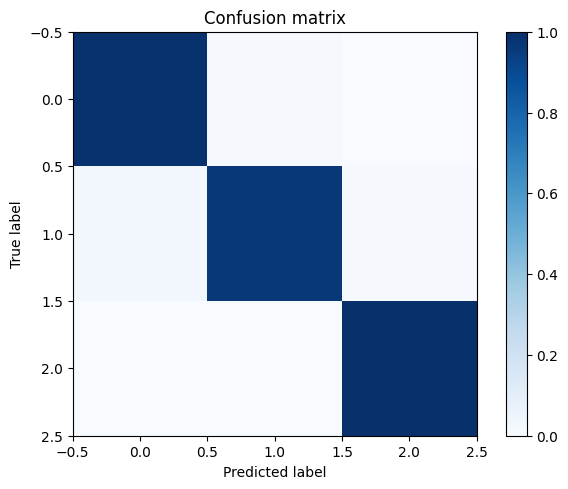

In [23]:
plot_confusion_matrix(
    cm,
    class_names,
    normalize = True,
    title = "Confusion matrix",
    cmap = plt.cm.Blues
    )

## II.4. Fine Tuning
This requires unfreezing the base model and then recompiling the model (necessary for the changes to take effect), and then resuming training.

### II.4.1. Unfreeze the base model

In [24]:
# Unfreeze the base model
base_model.trainable = True

### II.4.2. Re compile the model with a very low learning rate

In [25]:
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    optimizer = ft_compile_optimizer,
    loss = ft_compile_loss,
    metrics = ft_compile_metrics
)

### II.4.3. Retraining the model

In [26]:
# Resume training
ft_history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = ft_epochs,
    verbose = ft_verbose,
    callbacks = ft_callbacks_list
)

# Save the Fine tuned model
model.save(ft_fileh5_path)

Epoch 1/15
132/132 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9781 - Precision: 0.9810 - Recall: 0.9781
Epoch 1: val_loss improved from inf to 0.05372, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNetV2B1_L1N64L2N32RMS/EfficientNetV2B1_H5_Model/EfficientNetV2B1_FT_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 166s 922ms/step - loss: 0.0719 - accuracy: 0.9781 - Precision: 0.9810 - Recall: 0.9781 - val_loss: 0.0537 - val_accuracy: 0.9808 - val_Precision: 0.9816 - val_Recall: 0.9800 - lr: 1.0000e-05
Epoch 2/15
132/132 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9771 - Precision: 0.9787 - Recall: 0.9757
Epoch 2: val_loss improved from 0.05372 to 0.04775, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNetV2B1_L1N64L2N32RMS/EfficientNetV2B1_H5_Model/EfficientNetV2B1_FT_MCPBest.h5
132/132 [==============================] - 123s 928ms/step - loss: 0.0691 - accuracy: 0.9771 - Precision: 0.9787 - Recall: 0.9757 - val_loss: 0.0477 - val_accuracy: 0.9842 - val_Precision: 0.9850 - val_Recall: 0.9842 - lr: 1.0000e-05
Epoch 3/15
132/132 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9852 - Precision: 0.9866 - Recall: 0.9843
Epoch 3: val_loss improved from 0.04775 to 0.03996, saving model to /co

### II.4.4. Evaluation Fine Tune Model

In [27]:
# Evaluate the model on the Test Dataset using `evaluate`
# f1 = F1Score(test_generator.classes, Y_pred_classes)
ft_f1 = f1_score(test_generator.classes, Y_pred_classes, average = "macro")
print("F1 Score : ", ft_f1)
print("Evaluate on Test Data")
ft_results = model.evaluate(test_generator, batch_size = batch_size)

F1 Score :  0.9849567794827206
Evaluate on Test Data
19/19 [==============================] - 5s 241ms/step - loss: 0.0316 - accuracy: 0.9900 - Precision: 0.9900 - Recall: 0.9900


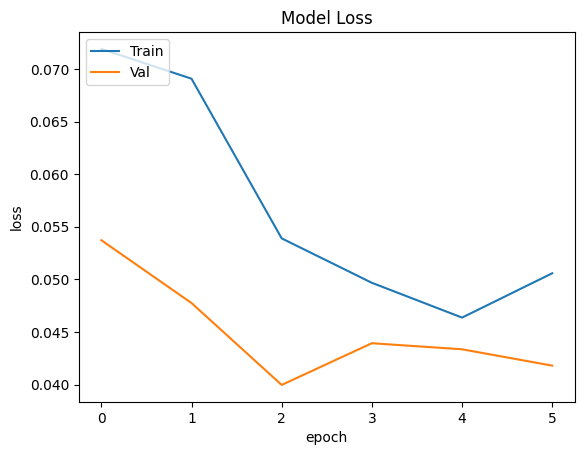

In [28]:
# Plot the Loss graph
plt.plot(ft_history.history["loss"])
plt.plot(ft_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

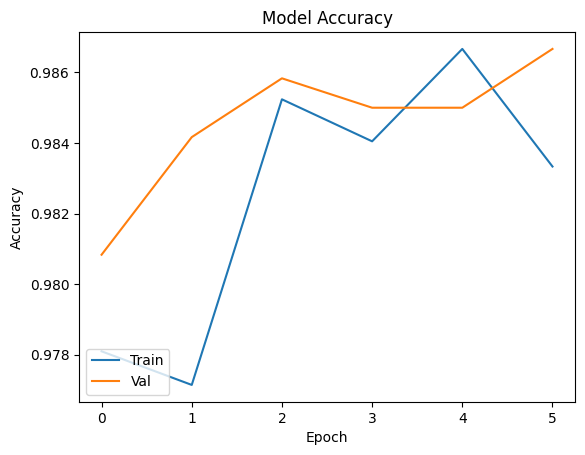

In [29]:
# Plot the Accuracy graph
plt.plot(ft_history.history["accuracy"])
plt.plot(ft_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

### II.4.5. Fine Tuned Model : Confusion Matrix

In [30]:
# # Predict the values from the validation dataset
# Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)

# # Convert predictions classes from one hot vectors
# Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convert validation observations from one hot vectors
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OR
Y_true = test_generator.classes

# Compute the confusion matrix
ft_cm = confusion_matrix(Y_true, Y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix")
print(ft_cm)

# Retrieve class names (label)
names_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(names_from_dir))
#OR
class_names = list(val_generator.class_indices.keys())
# Check if the both are similar
print(names_from_dir == class_names)

# Print the classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names, digits = 4))

Confusion Matrix
[[198   2   0]
 [  5 193   2]
 [  0   0 200]]
True
Classification Report
              precision    recall  f1-score   support

         Bee     0.9754    0.9900    0.9826       200
   Butterfly     0.9897    0.9650    0.9772       200
     Ladybug     0.9901    1.0000    0.9950       200

    accuracy                         0.9850       600
   macro avg     0.9851    0.9850    0.9850       600
weighted avg     0.9851    0.9850    0.9850       600



### II.4.5. Fine Tuned Model : Confusion Matrix Graph

Normalized confusion matrix
[[0.99  0.01  0.   ]
 [0.025 0.965 0.01 ]
 [0.    0.    1.   ]]


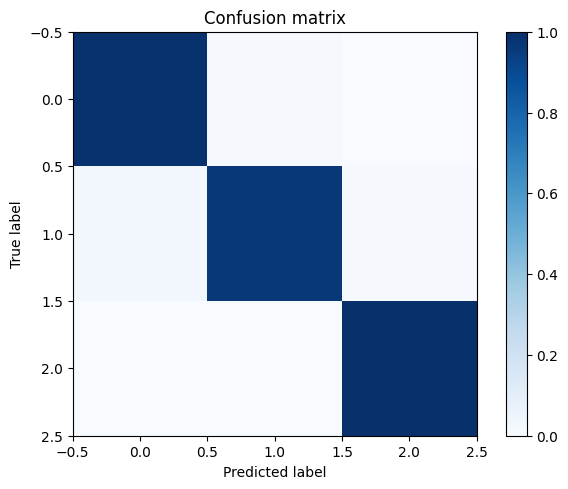

In [31]:
plot_confusion_matrix(ft_cm,
                      class_names,
                      normalize = True,
                      title = "Confusion matrix",
                      cmap = plt.cm.Blues
                      )